<div class='bar_title'></div>

*Introduction to Data Science (IDS)*

# Assignment 9 - Time Series Analysis Solutions
Gunther Gust / Vanessa Haustein <br>
Chair for Enterprise AI<br>
Data Driven Decisions (D3) Group<br>
Center for Artificial Intelligence and Data Science (CAIDAS)

<img src='https://raw.githubusercontent.com/vhaus63/ids_data/main/d3.png?raw=true' style='width:20%; float:left;' />

<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/CAIDASlogo.png" style="width:20%; float:left;" />


# Exercise 1: Onion Price Forecast in Bangalore

We want to predict the onion prices in Bangalore for the future using an ARIMA model. For this, we will use the cleaned MonthWiseMarketArrivals dataset:

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import kpss
from lets_plot import *
LetsPlot.setup_html()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/vhaus63/ids_data/refs/heads/main/MonthWiseMarketArrivals_Clean.csv')
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,January-2005
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,January-2006
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,January-2010
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,January-2011
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,January-2012


In order to be able to work properly with our dataset we need some preprocessing steps:
1. Change the date column to a Datetime Index column
2. Set the date as index
3. Sort the data frame by the new index

Thses steps are necessary to ensure that our model will later be able to understand the relationship between the date (and its frequency in months) and the value (the price) for fitting a model and forecasting.

In [4]:
# Change the date column to a Time Interval columnn
df['date'] = pd.DatetimeIndex(df['date'])

# Change the index to the date column
df.set_index('date', inplace=True, drop=False)

# Sort the data frame by date
df.sort_index(inplace=True)

df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
1996-01-01,LASALGAON(MS),January,1996,225063,160,257,226,MS,LASALGAON,1996-01-01
1996-02-01,LASALGAON(MS),February,1996,196164,133,229,186,MS,LASALGAON,1996-02-01
1996-03-01,LASALGAON(MS),March,1996,178992,155,274,243,MS,LASALGAON,1996-03-01
1996-04-01,LASALGAON(MS),April,1996,192592,136,279,254,MS,LASALGAON,1996-04-01
1996-05-01,LASALGAON(MS),May,1996,237574,154,312,269,MS,LASALGAON,1996-05-01


We want to forecast the onion price for Bangalore, so we have to filter our dataset for relevant observations. Additionally, the only information we will use in our model are the date, the `priceMod` and (for the second exercise) the quantity.

In [5]:
dfBang = df.loc[df.city == "BANGALORE"][['date', 'quantity', 'priceMod']].copy()
dfBang.head()

,date,quantity,priceMod
date,,,
2004-01-01,2004-01-01,227832,991
2004-02-01,2004-02-01,225133,793
2004-03-01,2004-03-01,221952,556
2004-04-01,2004-04-01,185150,465
2004-05-01,2004-05-01,137390,455


Plot the columns `priceMod` and `quantity` in two different plots. Afterwards, create a histogram of the `priceMod` in order to check if the data is normally distributed.

In [6]:
(
    ggplot(dfBang)
    + geom_line(aes(x='date', y='quantity'))
    + ggsize(1000, 400)
)

In [7]:
(
    ggplot(dfBang)
    + geom_line(aes(x='date', y='priceMod'))
    + ggsize(1000, 400)
)

In [8]:
(
    ggplot(dfBang, aes(x='priceMod')) + geom_histogram(bins=30, fill='blue')
    + ggtitle('Histogram of priceMod')
    + xlab('priceMod')
    + ylab('Frequency')
)

What do you observe about the data?

_Quantity:_

There is an obvious seasonal trend of one year length in the data. Additionally, the overall sales seem to have increased slightly over the years.

_priceMod:_

The data exhibits fluctuations in the spread or amplitude of the values over time, leading to the observation that the data is not stationary.

_Histogram:_

The data is right skewed and should therefore be log-transformed.

Apply an appropriate transformation to the price that makes it more normally distributed if necessary.

In [9]:
dfBang['priceModLog'] = np.log(dfBang.priceMod)
dfBang.head()

,date,quantity,priceMod,priceModLog
date,,,,
2004-01-01,2004-01-01,227832,991,6.898715
2004-02-01,2004-02-01,225133,793,6.675823
2004-03-01,2004-03-01,221952,556,6.320768
2004-04-01,2004-04-01,185150,465,6.142037
2004-05-01,2004-05-01,137390,455,6.120297


In [10]:
(
    ggplot(dfBang, aes(x='priceModLog')) + geom_histogram(bins=30, fill='blue')
    + ggtitle('Histogram of priceModLog')
    + xlab('priceModLog')
    + ylab('Frequency')
)

Now that the data looks more normally distributed, we can deal with the stationarity property. Is the transformed price stationary? Check this visually and with a KPSS test. Depending on the result of your inspection, take measures to turn the data into a stationary timeseries and confirm that it worked.

In [11]:
(
    ggplot(dfBang)
    + geom_line(aes(x='date', y='priceModLog'))
    + ggsize(1000, 400)
)

In [12]:
kpss(dfBang['priceModLog'])[1]

C:\Users\vah55ns\AppData\Local\Temp\ipykernel_3336\4083057465.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(dfBang['priceModLog'])[1]


0.01

The model is not stationary. 

In [13]:
dfBang["priceModLogDiff"] = dfBang.priceModLog.diff(1)

In [14]:
(
    ggplot(dfBang)
    + geom_line(aes(x='date', y='priceModLogDiff'))
    + ggsize(1000, 400)
)

In [15]:
kpss(dfBang['priceModLogDiff'].dropna())[1]

C:\Users\vah55ns\AppData\Local\Temp\ipykernel_3336\1080885887.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(dfBang['priceModLogDiff'].dropna())[1]


0.1

The first order differenciation helped turn our data into a normal distributed and stationary timeseries. Now we can apply the ARIMA model.

## Manually Fitting ARIMA
Look at the ACF and PACF plots of your (potentially transformed) data to guess good parameters for the ARIMA model. Fit this model.

C:\Users\vah55ns\AppData\Local\Temp\ipykernel_3336\2273584112.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_acf(dfBang['priceModLogDiff'][1:]).show()


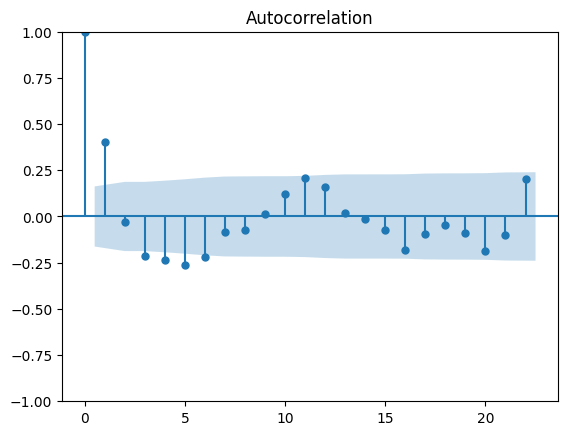

In [16]:
plot_acf(dfBang['priceModLogDiff'][1:]).show()

C:\Users\vah55ns\AppData\Local\Temp\ipykernel_3336\2492300670.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_pacf(dfBang['priceModLogDiff'][1:]).show()


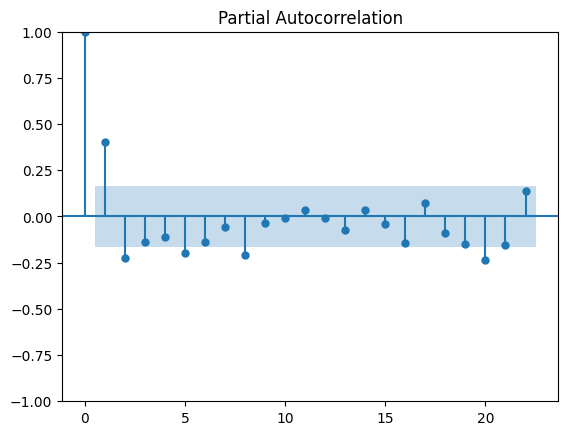

In [17]:
plot_pacf(dfBang['priceModLogDiff'][1:]).show()


From the plots we can see that we should use a ARIMA(1,1,1) model.

In [18]:
ts_Bang = dfBang['priceModLog']

In [19]:
model = ARIMA(ts_Bang, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\vah55ns\Documents\src\IDS\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\vah55ns\Documents\src\IDS\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\vah55ns\Documents\src\IDS\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            priceModLog   No. Observations:                  146
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  12.360
Date:                Sat, 18 Jan 2025   AIC                            -18.720
Time:                        11:15:53   BIC                             -9.790
Sample:                    01-01-2004   HQIC                           -15.091
                         - 02-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1581      0.212      0.746      0.456      -0.257       0.574
ma.L1          0.3216      0.180      1.787      0.074      -0.031       0.674
sigma2         0.0493      0.005     10.908      0.0

## Auto ARIMA
Now, try to find better parameters using the `auto_arima` function and an appropriate model selection metric. Check the residuals for the best model you could find.

In [20]:
auto_model = auto_arima(ts_Bang, information_criterion='aicc', trace=True, seasonal=False)
auto_model.summary()

Performing stepwise search to minimize aicc
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AICC=-39.762, Time=3.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AICC=9.807, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AICC=-13.916, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AICC=-17.584, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AICC=7.753, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AICC=-15.812, Time=4.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AICC=inf, Time=4.42 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AICC=inf, Time=4.06 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AICC=-34.783, Time=4.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AICC=-16.438, Time=0.60 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AICC=inf, Time=2.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AICC=inf, Time=3.85 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AICC=inf, Time=5.11 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AICC=-36.806, Time=2.10 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  146
Model:               SARIMAX(2, 1, 2)   Log Likelihood                  26.183
Date:                Sat, 18 Jan 2025   AIC                            -40.366
Time:                        11:16:28   BIC                            -22.506
Sample:                    01-01-2004   HQIC                           -33.109
                         - 02-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.001      2.844      0.004       0.001       0.004
ar.L1          1.3575      0.127     10.724      0.000       1.109       1.606
ar.L2         -0.6376      0.116     -5.506      0.000      -0.865      -0.411
ma.L1         -1.1248      0.166     -6.773      0.000      -1.450      -0.799
ma.L2          0.1525      0.167      0.912      0.362      -0.175       0.480
sigma2         0.0390      0.005      8.538      0.000       0.030       0.048
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                23.49
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.71
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

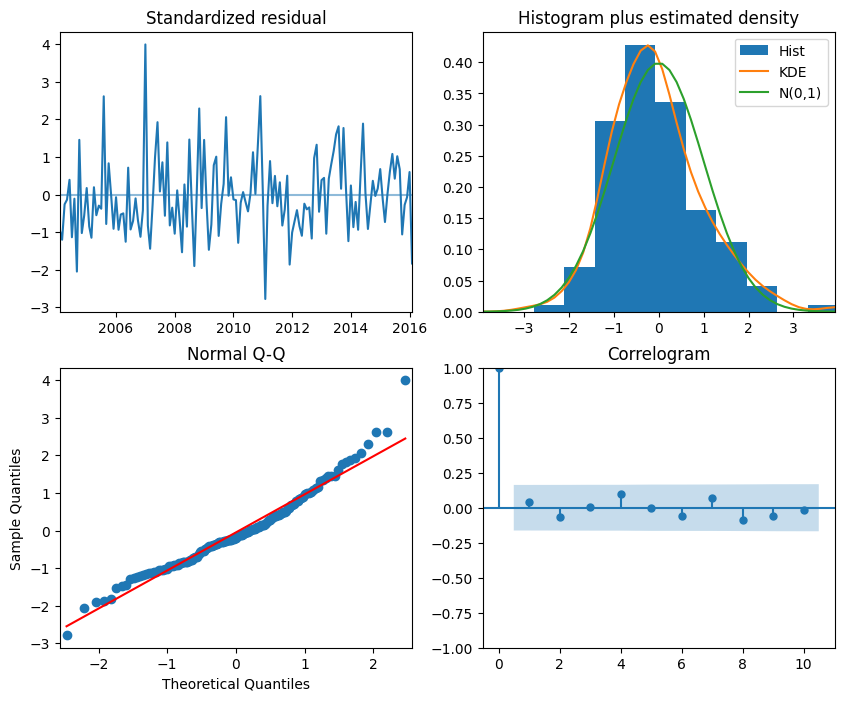

In [21]:
auto_model.plot_diagnostics(figsize=(10,8))
plt.show()

# Exercise 2: Onion Quantity Forecast in Bangalore

Now, use the prophet package to forecast the quantity of onion sales in Bangalore for the next 3 years. Plot your results as well as the decomposition of the timeseries. Why might it be a good idea to use this package instead of an ARIMA model?

In [22]:
dfBang

,date,quantity,priceMod,priceModLog,priceModLogDiff
date,,,,,
2004-01-01,2004-01-01,227832,991,6.898715,NaN
2004-02-01,2004-02-01,225133,793,6.675823,-0.222891
2004-03-01,2004-03-01,221952,556,6.320768,-0.355055
2004-04-01,2004-04-01,185150,465,6.142037,-0.178731
2004-05-01,2004-05-01,137390,455,6.120297,-0.021740
...,...,...,...,...,...
2015-10-01,2015-10-01,1612160,2215,7.703008,-0.348970
2015-11-01,2015-11-01,1071872,1618,7.388946,-0.314062
2015-12-01,2015-12-01,513186,1343,7.202661,-0.186285


In [23]:
df = dfBang[['date', 'quantity']].copy()
df.rename(columns={'date': 'ds', 'quantity': 'y'}, inplace=True)

m = Prophet()
m.fit(df)

11:16:29 - cmdstanpy - INFO - Chain [1] start processing
11:16:29 - cmdstanpy - INFO - Chain [1] done processing


c:\Users\vah55ns\Documents\src\IDS\env\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


<Figure size 1600x1000 with 0 Axes>

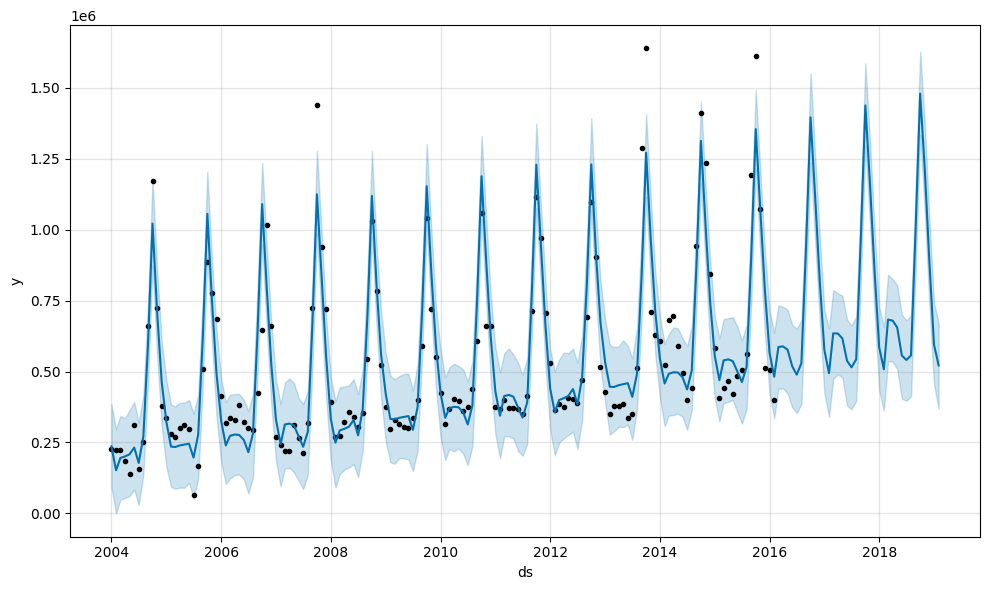

In [24]:
future = m.make_future_dataframe(periods=36, freq='M')
forecast = m.predict(future)

plt.figure(figsize=(16, 10))
m.plot(forecast)
plt.show()

<Figure size 1600x1000 with 0 Axes>

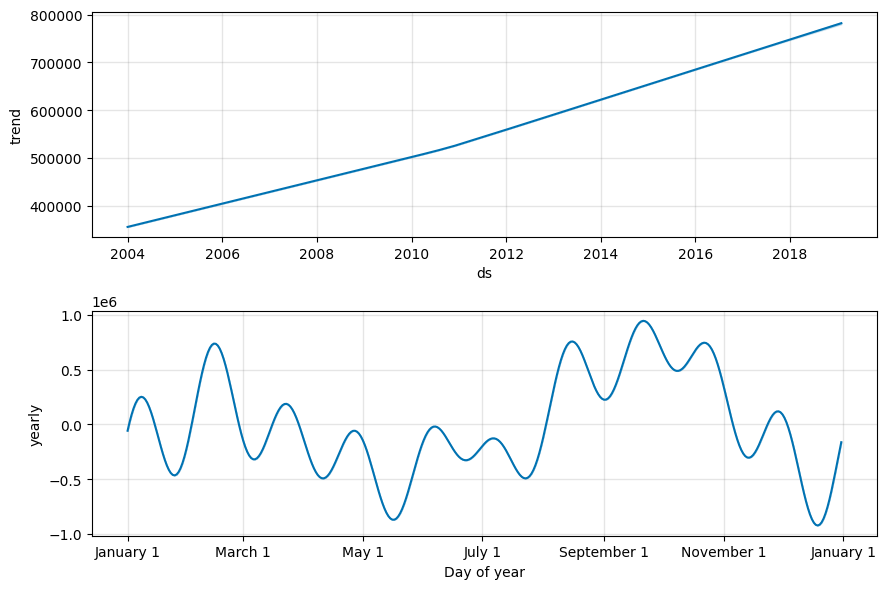

In [25]:
plt.figure(figsize=(16, 10))
m.plot_components(forecast)
plt.show()

It is better to use `Prophet` for forecasting in this case since we already saw strong seasonality and non-stationarity in the sales quantity in the beginning. It is particularly good at handling these timeseries even if we don't have specific domain knowledge about the seasonal effects. Additionally, it is very easy to train the model and no decisions need to be taken on parameters like in the ARIMA model. Still, the result is pretty good as we can see in the forecast.

# Exercise 3: Dealing with Non-Stationarity

Here are plots of three different datasets. Which one of these is stationary? Link them to their appropriate ACF/PACF plots.

<img src='https://raw.githubusercontent.com/vhaus63/ids_data/main/stationarity_check.png' style='width:90%; float:left;' />

ACF plots:

<img src='https://raw.githubusercontent.com/vhaus63/ids_data/main/output_acf.png' style='width:90%; float:left;' />


PACF plots:

<img src='https://raw.githubusercontent.com/vhaus63/ids_data/main/output_pacf.png' style='width:90%; float:left;' />


**Daily total female births**:

The data appears stationary, fluctuating around a constant mean with no apparent trend or seasonality.
This aligns with Data 3.

**international airlane passengers**:
The data shows a clear upward trend with seasonal fluctuations.
This pattern matches Data, where the ACF shows a slow decay (indicative of an AR process), and the PACF cuts off sharply after lag 1.

**shampoo sales**:

Strong upward trend: This dataset shows a steady upward trend but weaker seasonal behavior compared to the second dataset.
This corresponds to Data 2, where the ACF shows a damped sinusoidal pattern and the PACF cuts off after lag 2